In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import sqlite3
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import gensim
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix,auc,accuracy_score
from nltk.stem.porter import PorterStemmer
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
con = sqlite3.connect("database.sqlite") 
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

C:\Users\LENOVO\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
import pickle
def savetofile(obj,filename):
    pickle.dump(obj,open(filename+".p","wb"))
def openfromfile(filename):
    temp = pickle.load(open(filename+".p","rb"))
    return temp

In [25]:

from tqdm import tqdm

In [3]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score


In [4]:
filtered_data.head()


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [5]:
import nltk
nltk.download('stopwords')
sno=nltk.stem.SnowballStemmer('english')
stop = set(stopwords.words('english'))
def cleanhtml(sentence):
  cleanr=re.compile('<.*?>')
  cleantext=re.sub(cleanr,' ',sentence)
  return cleantext
def cleanpunc(sentence):
  cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
  cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned) 
  return cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))   

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
{'their', 'yours', 'd', 'have', 'up', 'my', 'll', 'nor', 'themselves', 'has', 'she', 's', "that'll", 'here', 'again', "hadn't", 'is', 'no', 're', 'by', "you'll", 'very', 'had', "you're", 'to', 've', 'such', 'same', 'but', 'for', "weren't", 'now', 'what', 'hasn', 'each', 'because', 'of', 'once', 'off', 'ma', 'be', 'from', 'any', 'against', 'he', 'out', 'why', 'that', 'both', "she's", "needn't", "shouldn't", 'not', 'itself', 'did', 'isn', 'm', 'needn', 'won', 'you', 'who', 'a', "shan't", 'shan', 'wasn', 'when', 'her', 'your', 'if', 'couldn', 'whom', 'after', 'below', 'few', 'do', 'those', "don't", "isn't", 'which', 'was', 'are', 'through', 'mightn', 'me', 'then', 'weren', 'doing', "hasn't", 'can', 'will', 'over', "couldn't", 'most', 'doesn', 'during', 'been', 'than', 'ourselves', "didn't", 'with', "it's", 'haven', 'an', 'too', "h

In [6]:
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
final = sorted_data.drop_duplicates(subset= { 'UserId', 'ProfileName', 'Time',  'Text'})

In [7]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

# Time based splitting

In [8]:
import datetime


In [9]:
final['Time'] = final['Time'].map(lambda t:datetime.datetime.fromtimestamp(int(t)).strftime('%Y-%m-%d %H:%M:%S'))

In [10]:
final["Time"].head()

138706    1999-10-08 05:30:00
138688    2007-11-11 05:30:00
138689    2007-10-04 05:30:00
138690    2004-02-06 05:30:00
138691    2002-04-10 05:30:00
Name: Time, dtype: object

In [11]:
final=final.sort_values('Time',axis=0,kind="quicksort", ascending=True).reset_index(drop=True)

In [14]:
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1
      
  


In [12]:
final_string = openfromfile('final_string')

In [13]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [36]:
final_sample=final['CleanedText'].values[0:100000]
final_score=final['Score'].values[0:100000]

In [74]:
all_positive_words=openfromfile('all_positive_words')
all_negative_words=openfromfile('all_negative_words')

In [75]:
freq_dist_positive=nltk.FreqDist(all_positive_words)
freq_dist_negative=nltk.FreqDist(all_negative_words)
print("Most Common Positive Words : ",freq_dist_positive.most_common(20))
print("Most Common Negative Words : ",freq_dist_negative.most_common(20))

Most Common Positive Words :  [(b'like', 139429), (b'tast', 129047), (b'good', 112766), (b'flavor', 109624), (b'love', 107357), (b'use', 103888), (b'great', 103870), (b'one', 96726), (b'product', 91033), (b'tri', 86791), (b'tea', 83888), (b'coffe', 78814), (b'make', 75107), (b'get', 72125), (b'food', 64802), (b'would', 55568), (b'time', 55264), (b'buy', 54198), (b'realli', 52715), (b'eat', 52004)]
Most Common Negative Words :  [(b'tast', 34585), (b'like', 32330), (b'product', 28218), (b'one', 20569), (b'flavor', 19575), (b'would', 17972), (b'tri', 17753), (b'use', 15302), (b'good', 15041), (b'coffe', 14716), (b'get', 13786), (b'buy', 13752), (b'order', 12871), (b'food', 12754), (b'dont', 11877), (b'tea', 11665), (b'even', 11085), (b'box', 10844), (b'amazon', 10073), (b'make', 9840)]


# FUNCTION FOR DECISION TREE  CLASSIFIER

In [22]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
def DECISIONTREECLASSIFIER(X_train,Y_train,X_test,Y_test,optimal_depth):
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import precision_score
    from sklearn.metrics import f1_score
    from sklearn.metrics import recall_score
    from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

    clf = DecisionTreeClassifier(max_depth = optimal_depth,class_weight="balanced")
    clf.fit(X_train,Y_train)
    pred = clf.predict(X_test)
    print(' accuracy with DEPTH =',optimal_depth,' is ' ,np.round((accuracy_score(Y_test, pred)*100),decimals = 2))
    print('F1 score with DEPTH =',optimal_depth,' is ' , np.round((f1_score(Y_test, pred,average= 'macro')*100),decimals = 2))
    print('Recall with DEPTH =',optimal_depth,' is ' , np.round((recall_score(Y_test, pred,average= 'macro')*100),decimals = 2))
    print('Precision with DEPTH =',optimal_depth,' is ' , np.round((precision_score(Y_test, pred,average= 'macro')*100),decimals = 2))
    print ('\n Classification report  with DEPTH =',optimal_depth,' is \n ' , classification_report(Y_test,pred)) 
   
    df_cm = pd.DataFrame(confusion_matrix(Y_test, pred), range(2),range(2))
    sns.set(font_scale=1.4)
    sns.heatmap(df_cm, annot=True,annot_kws={"size": 18}, fmt='g')
    print("**************************")
    print("train_score is",clf.score(X_train,Y_train))
    print("***************************")
    print("test_score is",clf.score(X_test,Y_test))
    

# CROSS VALIDATION SEARCH FOR MAX_DEPTH

In [29]:
from sklearn.cross_validation import cross_val_score
from sklearn import preprocessing
def Max_depth(X_train,Y_train):
    

    lb = preprocessing.LabelBinarizer()
    Y_train = np.array([number[0] for number in lb.fit_transform(Y_train)])
    
    import matplotlib.pyplot as plt
    cv_scores=[]
    clf = DecisionTreeClassifier(class_weight="balanced",max_features='auto')
    depth_params = list(range(2,100,2))
    for depth in tqdm(depth_params):
        
        clf = DecisionTreeClassifier(max_depth=depth)
        scores=cross_val_score(clf,X_train,Y_train,cv=7,scoring='f1')
        cv_scores.append(scores.mean())
    MSE = [1 - x for x in cv_scores] 
    optimal_depth = depth_params[MSE.index(min(MSE))]
    print("Max depth for Decision tree should be",optimal_depth) 
    plt.figure(figsize=(10,6))
    plt.plot(depth_params,MSE,color='blue')
    plt.title('CV SCORE ERROR VS MAX_DEPTH')
    plt.xlabel("max depth")
    plt.ylabel("ERROR RATE")
    return optimal_depth

# Bag of words

In [37]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(final_sample,final_score,test_size=0.3,shuffle=False)

In [38]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(ngram_range=(1,1))
Vocabulary = count_vect.fit_transform(X_train)


In [39]:
bow_X_train=count_vect.transform(X_train)
bow_X_test=count_vect.transform(X_test)

In [20]:
bow_X_train=bow_X_train
bow_X_test = bow_X_test


# BEST MAX DEPTH For bow

100%|███████████████████████████████████████████████████████████████████████████████| 49/49 [1:34:06<00:00, 182.79s/it]


Max depth for Decision tree should be 10


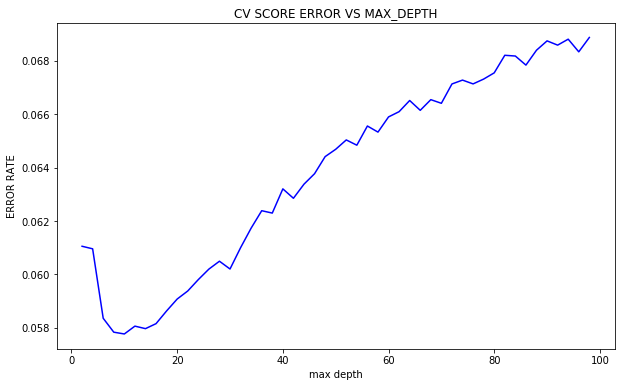

In [40]:
BestHyperparameter = Max_depth(bow_X_train,Y_train)

# DECISION TREE CLASSIFIER FOR BOW

 accuracy with DEPTH = 10  is  67.58
F1 score with DEPTH = 10  is  58.94
Recall with DEPTH = 10  is  72.55
Precision with DEPTH = 10  is  61.05

 Classification report  with DEPTH = 10  is 
               precision    recall  f1-score   support

   negative       0.27      0.79      0.40      4103
   positive       0.95      0.66      0.78     25897

avg / total       0.86      0.68      0.73     30000

**************************
train_score is 0.6850142857142857
***************************
test_score is 0.6758


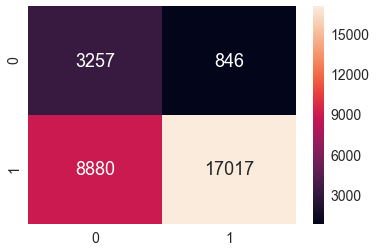

In [41]:
 DECISIONTREECLASSIFIER(bow_X_train,Y_train,bow_X_test,Y_test, 10 )

In [51]:
clf = DecisionTreeClassifier(max_depth = 10 ,class_weight="balanced")
clf.fit(bow_X_train,Y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=10, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

# TOP 25 MOST IMPORTANT FEATURES

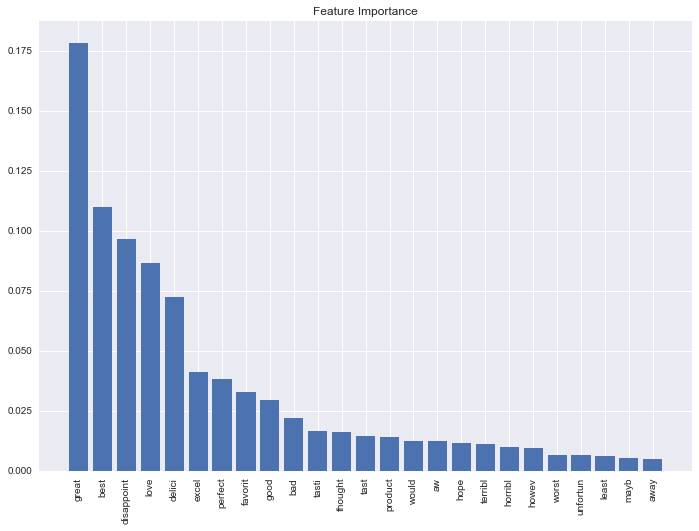

In [55]:
#code support from github
importances = clf.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1][:25]

# Rearrange feature names so they match the sorted feature importances
names = count_vect.get_feature_names()

sns.set(rc={'figure.figsize':(11.7,8.27)})

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(25), importances[indices])

# Add feature names as x-axis labels
names = np.array(names)
plt.xticks(range(25), names[indices], rotation=90)

# Show plot
plt.show()

## TFIDF

In [57]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(final_sample,final_score,test_size=0.3,shuffle=False)

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer()
Vocabulary = tfidf_vect.fit_transform(X_train)


In [59]:
tfidf_X_train=tfidf_vect.transform(X_train)
tfidf_X_test=tfidf_vect.transform(X_test)

In [60]:
tfidf_X_train.shape

(70000, 31373)

# BEST MAX DEPTH FOR TFIDF

100%|███████████████████████████████████████████████████████████████████████████████| 49/49 [1:48:00<00:00, 218.53s/it]


Max depth for Decision tree should be 12


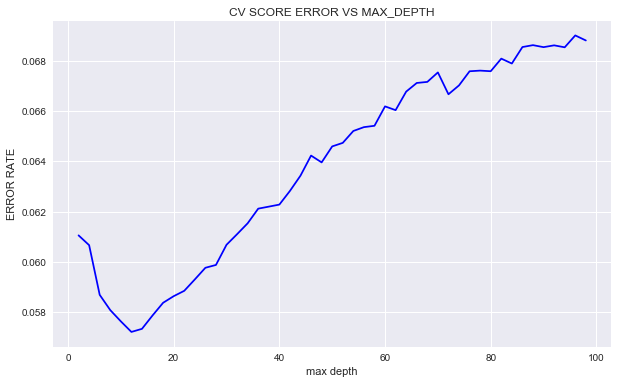

In [62]:
BestHyperparameter = Max_depth(tfidf_X_train,Y_train)

 accuracy with DEPTH = 12  is  72.1
F1 score with DEPTH = 12  is  61.98
Recall with DEPTH = 12  is  73.3
Precision with DEPTH = 12  is  62.14

 Classification report  with DEPTH = 12  is 
               precision    recall  f1-score   support

   negative       0.30      0.75      0.42      4103
   positive       0.95      0.72      0.82     25897

avg / total       0.86      0.72      0.76     30000

**************************
train_score is 0.7410142857142857
***************************
test_score is 0.7210333333333333


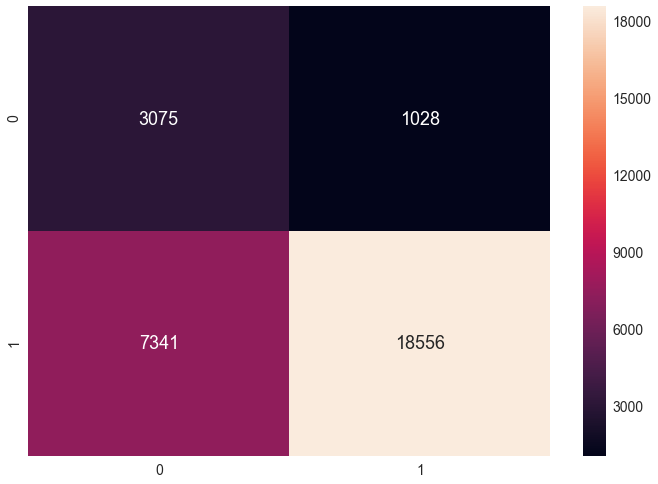

In [63]:
 DECISIONTREECLASSIFIER(tfidf_X_train,Y_train,tfidf_X_test,Y_test, 12  )

In [64]:
clf = DecisionTreeClassifier(max_depth = 12,class_weight="balanced")
clf.fit(tfidf_X_train,Y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=12, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

# TOP 25 MOST IMPORTANT FEATURES

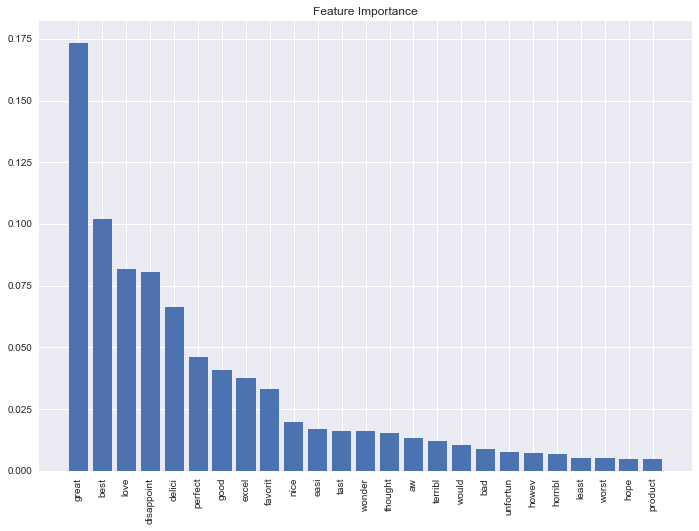

In [65]:
importances = clf.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1][:25]

# Rearrange feature names so they match the sorted feature importances
names = count_vect.get_feature_names()

sns.set(rc={'figure.figsize':(11.7,8.27)})

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(25), importances[indices])

# Add feature names as x-axis labels
names = np.array(names)
plt.xticks(range(25), names[indices], rotation=90)

# Show plot
plt.show()

# Word 2 vec

In [66]:
X_Train,X_Test,Y_train,y_test = train_test_split(final['CleanedText'],final['Score'])


In [83]:
i=0
list_of_sent1=[]
for sent in tqdm(final['CleanedText']):
    
    list_of_sent1.append(sent.split())

100%|████████████████████████████████████████████████████████████████████████| 364171/364171 [01:12<00:00, 5052.58it/s]


In [68]:
W2v_model = gensim.models.Word2Vec(list_of_sent1,min_count=5,size=50, workers=4)

In [71]:
w2v_words = list(W2v_model.wv.vocab)


In [73]:
sent_vectors = []; 
for sent in tqdm(list_of_sent1): 
    sent_vec = np.zeros(50)
    cnt_words =0; 
    for word in sent:
        if word in w2v_words:
            vec = W2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|█████████████████████████████████████████████████████████████████████████| 273128/273128 [06:53<00:00, 660.01it/s]


273128
50


In [86]:
sent_vectors=openfromfile('sent_vectors')

In [87]:
len(sent_vectors)

364171

In [88]:
final_w2v_sample = np.array(sent_vectors)
final_w2v_sample=final_w2v_sample[0:100000]

In [89]:

from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(final_w2v_sample,final_score,test_size=0.3,shuffle=False)

In [90]:
avgw2v_X_train = X_train
avgw2v_X_test = X_test

In [91]:
avgw2v_X_train.shape

(70000, 50)

# BEST MAX DEPTH FOR AVG WORD 2 VEC

100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [36:22<00:00, 46.72s/it]


Max depth for Decision tree should be 6


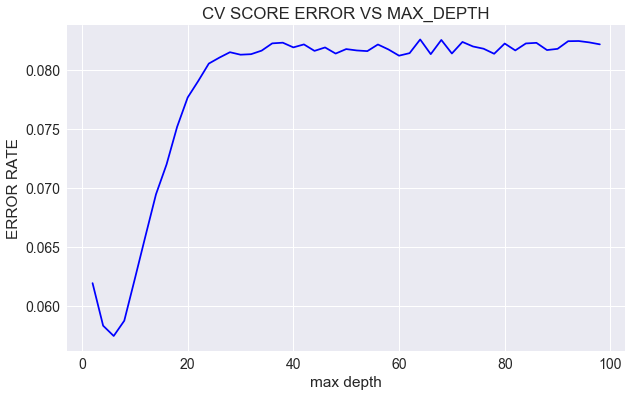

In [92]:
BestHyperparameter = Max_depth(avgw2v_X_train,Y_train)

In [31]:
print(BestHyperparameter)

6


# DECISION TREE CLASSIFIER for Average Word 2 Vec

 accuracy with DEPTH = 6  is  76.09
F1 score with DEPTH = 6  is  66.05
Recall with DEPTH = 6  is  77.46
Precision with DEPTH = 6  is  64.92

 Classification report  with DEPTH = 6  is 
               precision    recall  f1-score   support

   negative       0.34      0.79      0.48      4103
   positive       0.96      0.76      0.85     25897

avg / total       0.87      0.76      0.79     30000

**************************
train_score is 0.7694571428571428
***************************
test_score is 0.7609


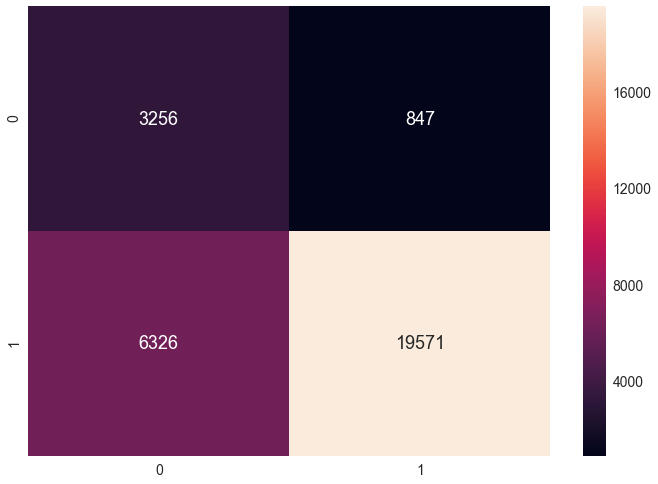

In [93]:
DECISIONTREECLASSIFIER(avgw2v_X_train,Y_train,avgw2v_X_test,Y_test,6)

# TFIDF WORD 2 Vec

In [78]:

i=0
list_of_sent1=[]
for sent in final['CleanedText'].values:
    list_of_sent1.append(sent.split())

In [75]:
model = TfidfVectorizer()

tf_idf_matrix = model.fit_transform(final['CleanedText'].values[0:50000])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [79]:
import os
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
w2v_words=list(W2v_model.wv.vocab)

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent1): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = W2v_model.wv[word]
            tfidf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tfidf)
            weight_sum += tfidf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 50000/50000 [14:34<00:00, 57.19it/s]


In [96]:
tfidf_sent_vectors=openfromfile('tfidf_sent_vectors')

In [97]:
len(tfidf_sent_vectors)

364171

In [98]:
tfidf_sent_vectors=tfidf_sent_vectors[0:100000]

In [99]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(tfidf_sent_vectors,final_score,test_size=0.3,shuffle=False)

In [100]:
tfidf_w2v_X_train= X_train
tfidf_w2v_X_test = X_test

# max depth for TFIDF W2v

100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [37:04<00:00, 53.23s/it]


Max depth for Decision tree should be 6


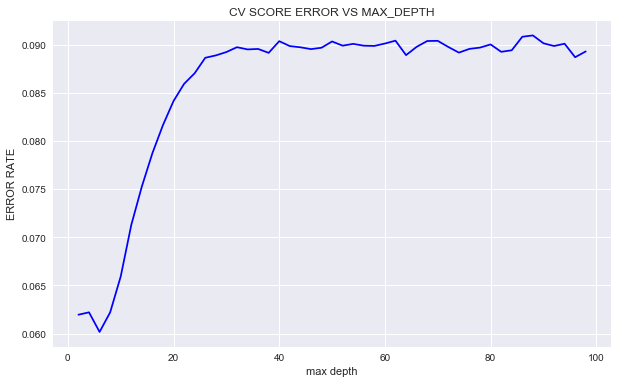

In [102]:
BestHyperparameter = Max_depth(tfidf_w2v_X_train,Y_train)

In [84]:
print(BestHyperparameter)

4


# DECISION TREE Classifier for tfidf word 2 vec

 accuracy with DEPTH = 6  is  72.25
F1 score with DEPTH = 6  is  62.31
Recall with DEPTH = 6  is  74.0
Precision with DEPTH = 6  is  62.46

 Classification report  with DEPTH = 6  is 
               precision    recall  f1-score   support

   negative       0.30      0.76      0.43      4103
   positive       0.95      0.72      0.82     25897

avg / total       0.86      0.72      0.76     30000

**************************
train_score is 0.7326428571428572
***************************
test_score is 0.7224666666666667


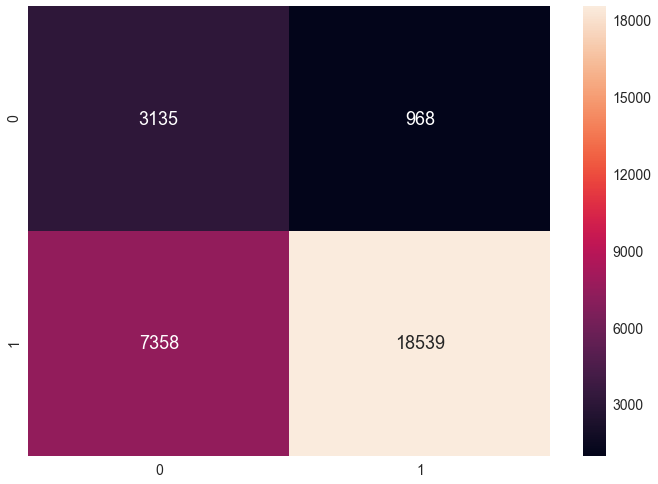

In [103]:
DECISIONTREECLASSIFIER(tfidf_w2v_X_train,Y_train,tfidf_w2v_X_test,Y_test,6)

# PERFORMANCE TABLE FOR DECISION TREE CLASSIFIER

| VECTORIZER | MAX DEPTH | TRAIN ERROR | TEST ERROR |
| --- | --- | --- | --- |
| Bow | 10 | 0.68   | 0.67   | 
| tfidf | 12 | 0.74 |  0.72  | 
| avg w2v | 6 | 0.76   |  0.76  | 
| tfidf w2v | 6 | 0.73   |  0.72  | 


observation-
1.decision tree doesnt work well with large dimensional data such as bow and tfidf because of high training time

2.as depth increases , the chances of overfitting increases